## Generate synthetic Anomalies

trying to replicate the synthethic anomalies from the LOE paper

https://arxiv.org/abs/2202.08088
"""
Since the MVTEC training set contains
no anomalies, we contaminate it with artificial anomalies
that we create by adding zero-mean Gaussian noise to the
features of test set anomalies. We use a large variance for
the additive noise (equal to the empirical variance of the
anomalous features) to reduce information leakage from the
test set into the training set.
"""


$$X = \text{Wideresnet or other embeddings},A = \text{Real Anomalies}, S = \text{Synthethic Anomalies}$$
Assumed A is multivariate Gauss (which they are most probably not):
$$\mathbf{A} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}_{A})$$
They assume noise $\mathbf{\epsilon}$ to be added to the anomalies of the testset which increases the variance of S:
$$\mathbf{\epsilon} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma_{A}})$$
Therefore:
$$\mathbf{S} \sim \mathcal{N}(\boldsymbol{\mu},  \boldsymbol{\Sigma_{A}} + \boldsymbol{\Sigma_{A}})$$

In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from sklearn.model_selection import train_test_split
import torch.nn as nn
import sys
sys.path.append('..')
from utils.helpers import *
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [2]:
# set the embeddings & read it 
FILENAME =  'MVTEC_WIDERESNET50_3thBlock_embeddings_df'#'MVTEC_CLIP_embeddings_df'#'MVTEC_WIDERESNET50_3thBlock_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

In [3]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'scratch','squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'combined','contamination', 'crack', 'faulty_imprint', 'pill_type','scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck','thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil','rough'],
    'toothbrush': ['defective'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'combined','fabric_border', 'fabric_interior','split_teeth','rough', 'squeezed_teeth']}


# change class here
category='zipper'
#number of synthetic anomalies to create
n_synthetic=30

info={'filename':FILENAME,'category':category,'n_synthetic':n_synthetic}

# create synthetic anomalies
combined_samples,labels,class_list= create_synset_for_class(category,df,n_synthetic)

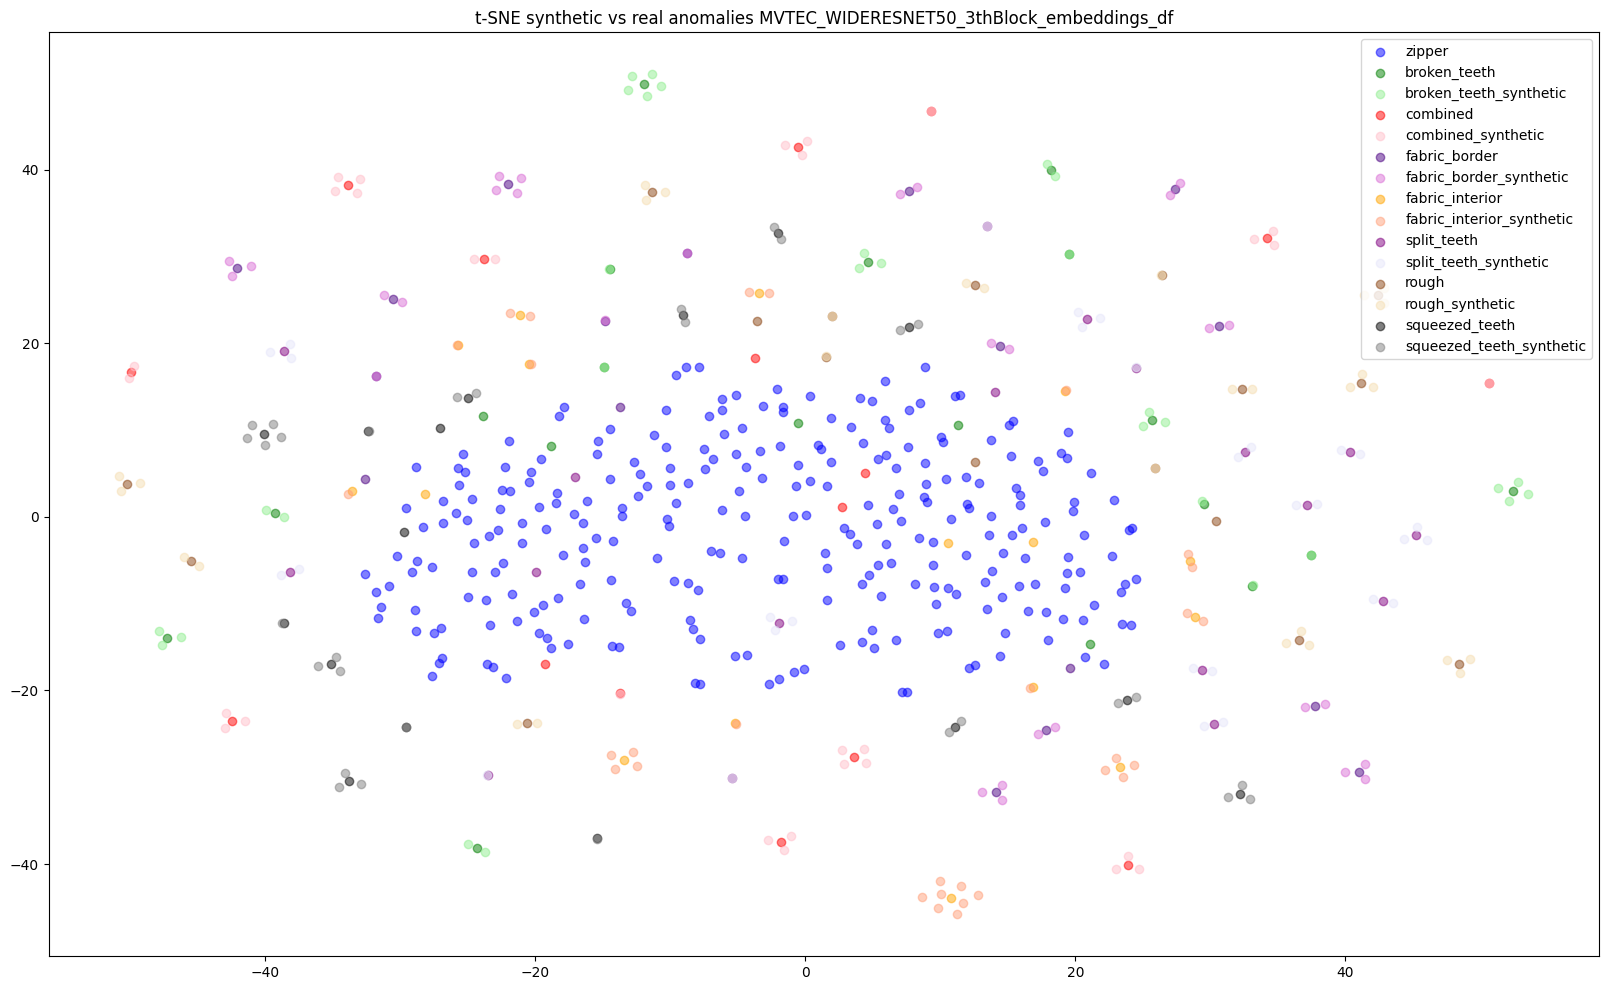

In [4]:
for _ in range(1):
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    reduced_data = tsne.fit_transform(combined_samples)
    colors = ['blue', 'green', 'lightgreen', 'red', 'pink', 'indigo', 'orchid', 'orange', 'lightsalmon', 'purple', 'lavender', 'saddlebrown', 'wheat', 'black', 'gray','olive', 'palegreen']
    jitter_amount = 0.3
    # Plotting
    plt.figure(figsize=(20, 12))
    for i in range(len(class_list)):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])
        
    plt.title(f't-SNE synthetic vs real anomalies {FILENAME}')
    plt.legend()
    plt.show()

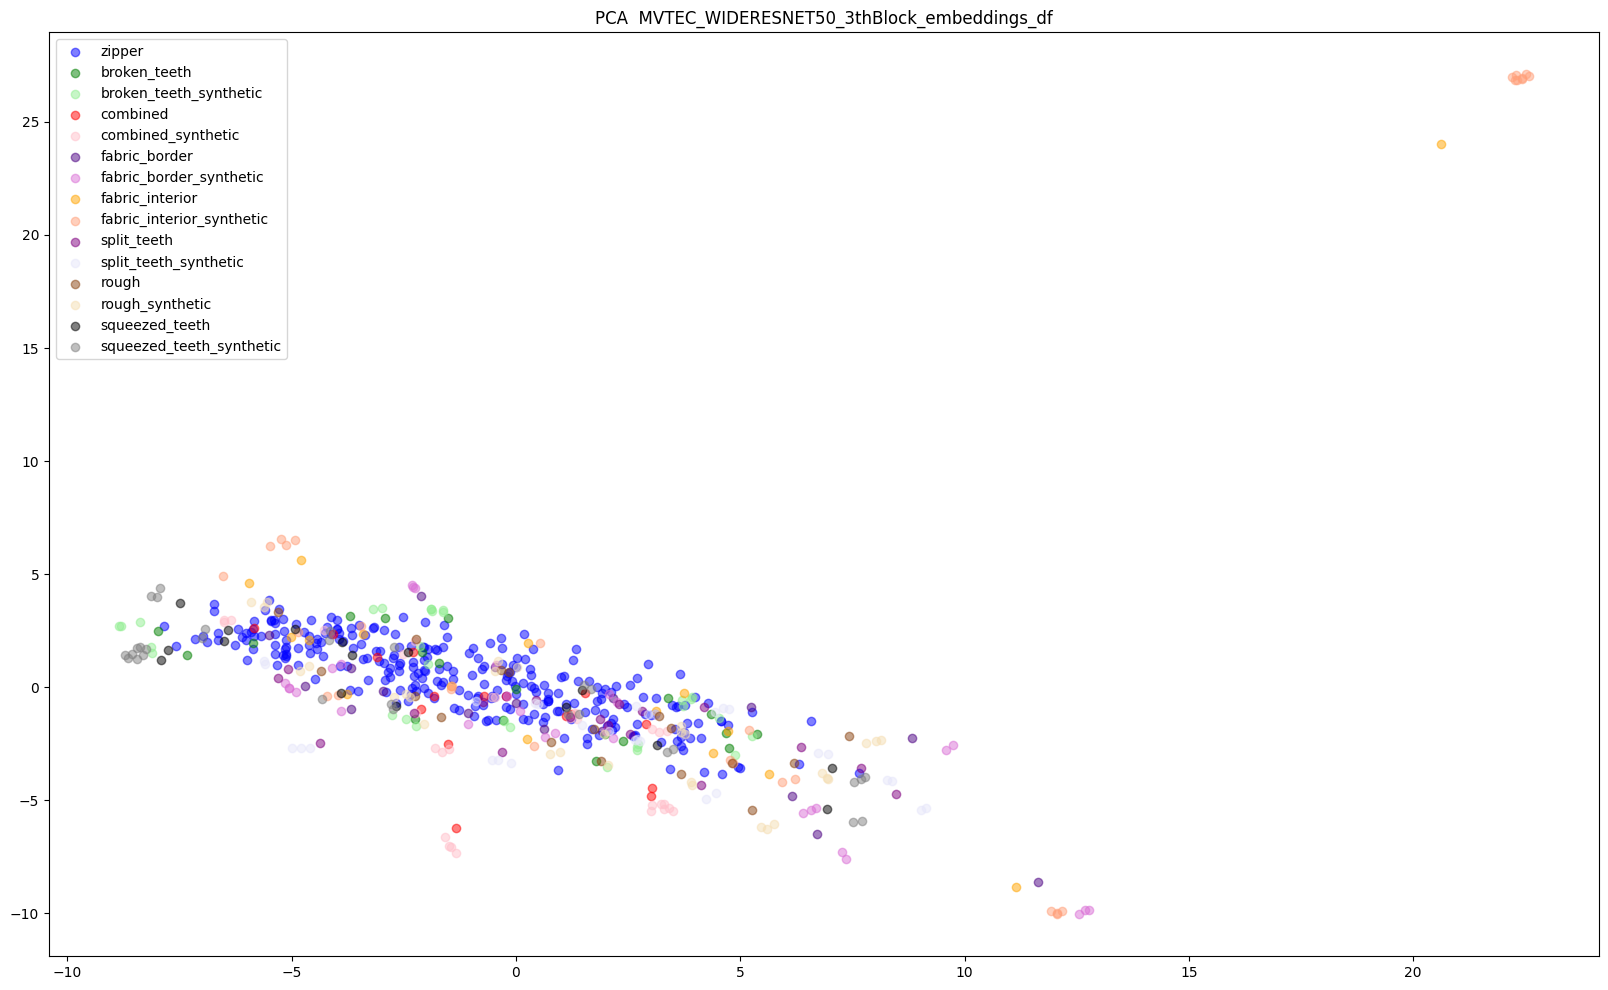

In [5]:
# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_samples)

# Plotting
plt.figure(figsize=(20, 12))
# Iterate over each unique label to plot them separately
for i in range(len(class_list)):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])

plt.title(f'PCA  {FILENAME}')
plt.legend()
plt.show()


## Autoencoder

- train autencoder to see wheter synthetic anomalies are valid or not

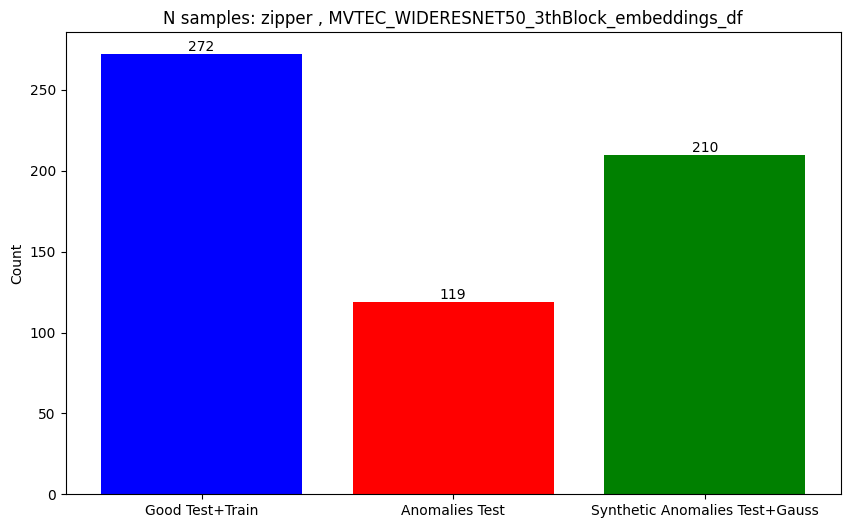

In [6]:
# filter for the synthetic and real anomalies
normals=combined_samples[labels==0]
anomalies=combined_samples[(labels % 2 != 0) & (labels != 0)] 
synthetic_anomalies=combined_samples[(labels % 2 == 0) & (labels != 0)] 
# plot it
plot_data_distribution(normals, anomalies, synthetic_anomalies,info=info)


### train on normal data

Epoch [1/30], Train Loss: 102.5822, Validation Loss: 0.0189
Epoch [2/30], Train Loss: 0.0189, Validation Loss: 0.0186
Epoch [3/30], Train Loss: 0.0181, Validation Loss: 0.0175
Epoch [4/30], Train Loss: 0.0169, Validation Loss: 0.0163
Epoch [5/30], Train Loss: 0.0157, Validation Loss: 0.0152
Epoch [6/30], Train Loss: 0.0147, Validation Loss: 0.0141
Epoch [7/30], Train Loss: 0.0137, Validation Loss: 0.0132
Epoch [8/30], Train Loss: 0.0128, Validation Loss: 0.0124
Epoch [9/30], Train Loss: 0.0120, Validation Loss: 0.0116
Epoch [10/30], Train Loss: 0.0112, Validation Loss: 0.0109
Epoch [11/30], Train Loss: 0.0106, Validation Loss: 0.0103
Epoch [12/30], Train Loss: 0.0100, Validation Loss: 0.0097
Epoch [13/30], Train Loss: 0.0094, Validation Loss: 0.0092
Epoch [14/30], Train Loss: 0.0089, Validation Loss: 0.0087
Epoch [15/30], Train Loss: 0.0085, Validation Loss: 0.0083
Epoch [16/30], Train Loss: 0.0081, Validation Loss: 0.0080
Epoch [17/30], Train Loss: 0.0078, Validation Loss: 0.0077
Epoc

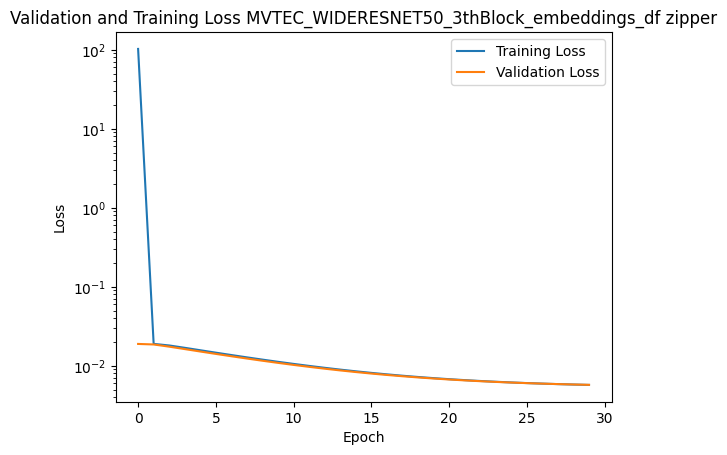

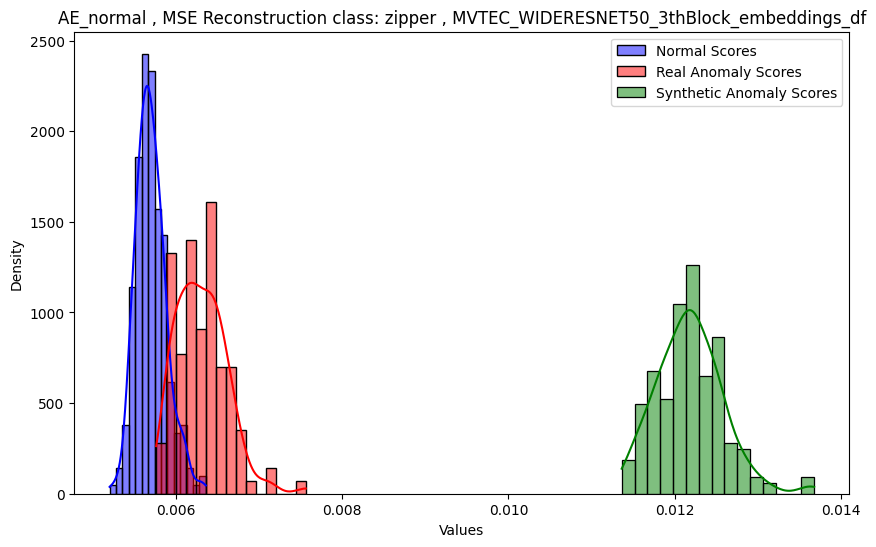

In [7]:


normal_data = torch.tensor(normals)
autoencoder_normal=train_autoencoder(normal_data, num_epochs=30,info=info)

normal_scores=np.mean((autoencoder_normal(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Real Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_normal , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

### Train on synthetic data

Epoch [1/30], Train Loss: 107.6370, Validation Loss: 0.0237
Epoch [2/30], Train Loss: 0.0240, Validation Loss: 0.0240
Epoch [3/30], Train Loss: 0.0237, Validation Loss: 0.0234
Epoch [4/30], Train Loss: 0.0230, Validation Loss: 0.0225
Epoch [5/30], Train Loss: 0.0221, Validation Loss: 0.0217
Epoch [6/30], Train Loss: 0.0213, Validation Loss: 0.0208
Epoch [7/30], Train Loss: 0.0205, Validation Loss: 0.0200
Epoch [8/30], Train Loss: 0.0197, Validation Loss: 0.0193
Epoch [9/30], Train Loss: 0.0190, Validation Loss: 0.0186
Epoch [10/30], Train Loss: 0.0183, Validation Loss: 0.0180
Epoch [11/30], Train Loss: 0.0177, Validation Loss: 0.0174
Epoch [12/30], Train Loss: 0.0172, Validation Loss: 0.0169
Epoch [13/30], Train Loss: 0.0166, Validation Loss: 0.0164
Epoch [14/30], Train Loss: 0.0162, Validation Loss: 0.0160
Epoch [15/30], Train Loss: 0.0157, Validation Loss: 0.0156
Epoch [16/30], Train Loss: 0.0153, Validation Loss: 0.0152
Epoch [17/30], Train Loss: 0.0150, Validation Loss: 0.0149
Epoc

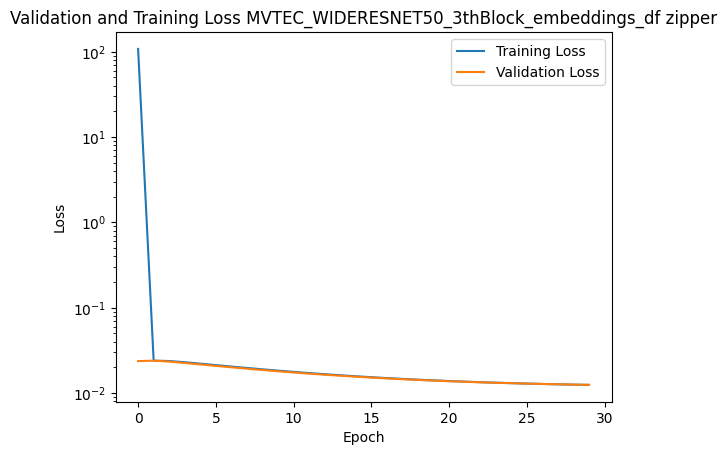

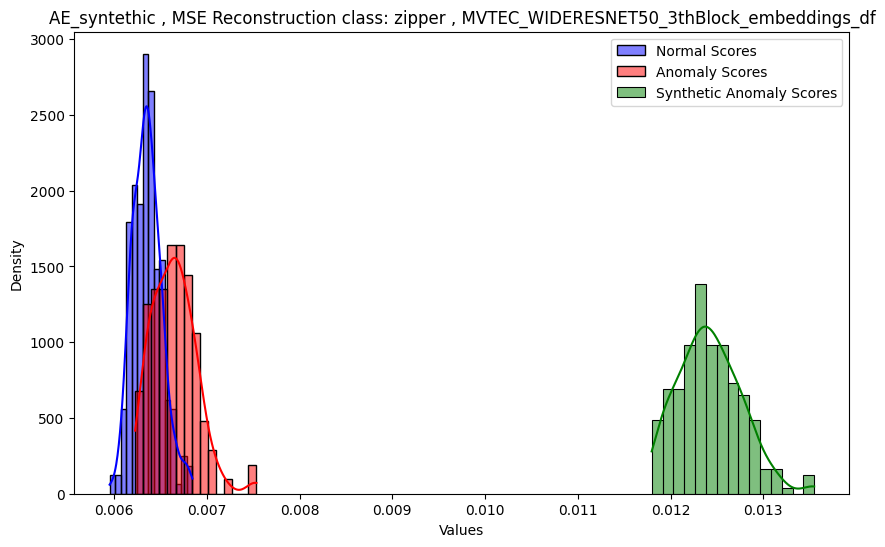

In [8]:
synthethicdata = torch.tensor(synthetic_anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(synthethicdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_syntethic , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

### Train on anomalies

Epoch [1/30], Train Loss: 113.7626, Validation Loss: 0.0541
Epoch [2/30], Train Loss: 0.4891, Validation Loss: 0.0182
Epoch [3/30], Train Loss: 0.0185, Validation Loss: 0.0186
Epoch [4/30], Train Loss: 0.0185, Validation Loss: 0.0182
Epoch [5/30], Train Loss: 0.0197, Validation Loss: 0.0176
Epoch [6/30], Train Loss: 0.0173, Validation Loss: 0.0169
Epoch [7/30], Train Loss: 0.0166, Validation Loss: 0.0162
Epoch [8/30], Train Loss: 0.0159, Validation Loss: 0.0155
Epoch [9/30], Train Loss: 0.0152, Validation Loss: 0.0148
Epoch [10/30], Train Loss: 0.0145, Validation Loss: 0.0142
Epoch [11/30], Train Loss: 0.0139, Validation Loss: 0.0136
Epoch [12/30], Train Loss: 0.0134, Validation Loss: 0.0131
Epoch [13/30], Train Loss: 0.0128, Validation Loss: 0.0126
Epoch [14/30], Train Loss: 0.0124, Validation Loss: 0.0121
Epoch [15/30], Train Loss: 0.0119, Validation Loss: 0.0117
Epoch [16/30], Train Loss: 0.0115, Validation Loss: 0.0113
Epoch [17/30], Train Loss: 0.0111, Validation Loss: 0.0109
Epoc

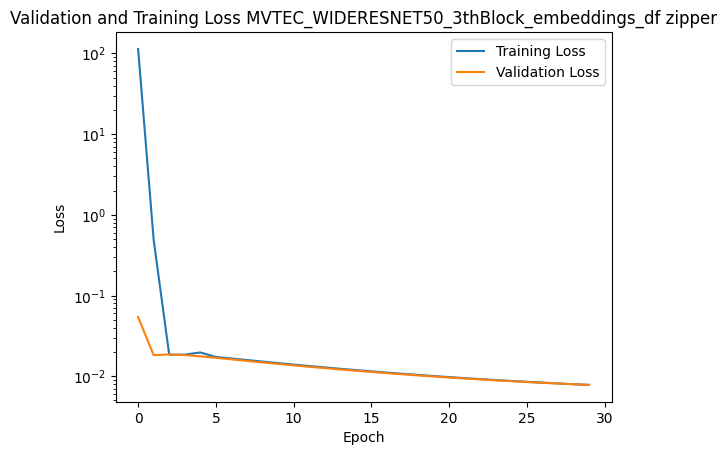

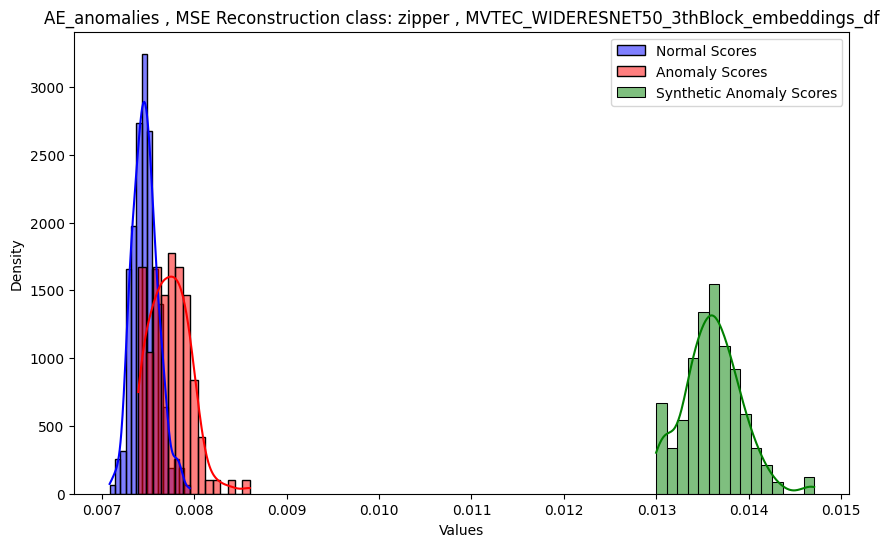

In [9]:
anomaliesdata = torch.tensor(anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(anomaliesdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_anomalies , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()